# Computational physics - Homework 4
 Francesco Emanuele Marcolini, Chiara Simonazzi, Giacomo Marcon.

To apply the Variational Monte Carlo method we start by evaluating the expectation of the Hamiltonian of a quantum system on a state $\psi_T( {\alpha} )$, following the Monte Carlo integration method: 

$$
E_T({\alpha})=\frac{\bra{\Psi_T({\alpha})}\hat H \ket{\Psi_T({\alpha},X)}}{\bra{\Psi_T({\alpha})}\ket{\Psi_T({\alpha})}}=\frac{\displaystyle \int dX|\Psi_T({\alpha},X)|^2 \frac{\hat H \Psi_T({\alpha},X)}{\Psi_T({ \alpha },X)}}{\displaystyle \int dX|\Psi_T({\alpha},X)|^2}
$$

According to the variational principle: $E_T({\alpha}) \geq E_0$, where $E_0$ is the ground state eigenvalue of the Hamiltonian. The equality holds if and only if $\ket{\Psi_T({\alpha})}\ \geq \ket{\Psi_0}$. 

The integral is estimated by means of the Metropolis algorithm, sampling from a probability density:
$$
P_{|\alpha|}(X)=\frac{|\Psi_T({\alpha},X)|^2}{\displaystyle \int dX\left|\Psi_T\left({\alpha},X\right)\right|^2}
$$
and averaging the so called local energy:
$$
E_L\left(\alpha\right)=\frac{\hat H \Psi_T({\alpha},X)}{\Psi_T({\alpha},X)}
$$

and its square over the sampled values of $X$ in order to obtain the estimate of $E_T(\alpha)$ and the corresponding error. The parameters are changed to minimize $E_T$.

Additionally, we can rearrange the laplacian term of the energy functional to obtain three equivalent but uncorrelated estimators for the kinetic part of the local energy, these three estimators are: 

$$
\begin{aligned}
K_1 =& -\frac{\hbar^2}{2m} frac{\nabla^2 \Psi_T(\alpha,X)}{\Psi_T(\alpha,X)},\\
K_2 =& \frac{\hbar^2}{2m} |\frac{\nabla \Psi_T(\alpha,X)}{\Psi_T(\alpha,X)}|^2,\\
K_3 =& \frac{1}{2}(K' + K''). 
\end{aligned}
$$

These estimators allows us to check for the correctness of the algorithms, as a mistake in the energy estimator or in the sampling procedure would result in a discrepancy between the three, uncorrelated, estimators.

We consider the 1-dimensional harmonic oscillator with Hamiltonian: 
$$
\hat H=-\frac{1}{2}\frac{d^2}{dx^2}+\frac{1}{2}x^2.
$$

The analytic expression of the local energy for a wavefunction is:
$$
\psi_T(x,\alpha)=e^{-\frac{x^2}{2\alpha^2}},
$$
where $ \alpha=1 $ gives the expected result. 


In [ ]:
from abc import ABC, abstractmethod
import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy.stats import binned_statistic
from scipy.integrate import simpson
from matplotlib.ticker import StrMethodFormatter
from matplotlib.ticker import FormatStrFormatter

In [ ]:
class Walker(ABC):
    def __init__(self, position: np.array):
        if position.shape != self.position_shape():
            raise KeyError('Position shape is wrong')
        self.position = position
        self.logprobability = 0
        self.localenergy = 0
        self.localenergysq = 0
        self.localK1 = 0
        self.localK2 = 0
        self.localK3 = 0
        self.localK1sq = 0
        self.localK2sq = 0
        self.localK3sq = 0

    def move(self, step: np.array):        
        if step.shape != self.position_shape():
            raise KeyError('Step shape is wrong')
        self.position += step    

    def set_logprobability(self, logprobability):
        self.logprobability = logprobability        
    
    def compute_localenergy(self):
        self.compute_Kinetic()
        self.localenergy = self.localK1 + self.compute_U()
        self.localenergysq = self.localenergy ** 2

    def update_observables(self): # not logprobability, the other (eventual) observables)
        self.compute_localenergy()

    @abstractmethod
    def position_shape(self) -> tuple: 
        pass
    
    @abstractmethod
    def compute_logprobability(self):
        pass

    @abstractmethod
    def compute_Kinetic(self):
        pass
    
    @abstractmethod
    def compute_U(self):
        pass

In [ ]:
def mrt(walker: Walker, delta: float):
    step = np.random.uniform(-delta, delta, walker.position_shape())
    prev_logprob = walker.logprobability # Walker needs to be initialized to a valid probability 
    walker.move(step)
    walker.compute_logprobability()
    new_logprob = walker.logprobability

    q = np.min([1, np.exp(new_logprob - prev_logprob)])
    if np.random.uniform(0, 1) < q:
        walker.update_observables()
        return 1 # step got accepted
    
    walker.move(-step) # step got rejected
    walker.set_logprobability(prev_logprob)
    return 0

In [ ]:
class IntegrateObservables:
    def __init__(self,
                 walker,
                 n_steps: int,
                 delta: float,
                 compute_Kestimators: bool = True
                 ):
        self.walker = walker
        self.walker.compute_logprobability()
        self.walker.compute_localenergy()
        self.n_steps = n_steps
        self.delta = delta
        # observables
        self.positions = np.zeros((n_steps,) + walker.position_shape())
        self.energies = np.zeros(n_steps)        
        self.energiessq = np.zeros(n_steps)
        self.compute_Kestimators = compute_Kestimators
        if self.compute_Kestimators:
            self.K1 = np.zeros(n_steps)
            self.K2 = np.zeros(n_steps)
            self.K3 = np.zeros(n_steps)
            self.K1sq = np.zeros(n_steps)
            self.K2sq = np.zeros(n_steps)
            self.K3sq = np.zeros(n_steps)
        # utils
        self.num_accepted = 0
    
    def run(self):
        if not self.compute_Kestimators:
            for step in range(self.n_steps):
                self.positions[step] = self.walker.position
                self.energies[step] = self.walker.localenergy
                self.energiessq[step] = self.walker.localenergysq
                self.num_accepted += mrt(self.walker, self.delta)
                # progress bar
                if step % 1000 == 0:
                    sys.stdout.write('\r')
                    sys.stdout.write("step {:d} / {:d} acceptance probability = {:.2f}".format(step+1, self.n_steps, self.num_accepted / (step + 1)))
                    sys.stdout.flush()
            sys.stdout.write('\r')
        else: 
            for step in range(self.n_steps):
                self.positions[step] = self.walker.position
                self.energies[step] = self.walker.localenergy
                self.energiessq[step] = self.walker.localenergysq
                self.K1[step] = self.walker.localK1
                self.K2[step] = self.walker.localK2
                self.K3[step] = self.walker.localK3
                self.K1sq[step] = self.walker.localK1sq
                self.K2sq[step] = self.walker.localK2sq
                self.K3sq[step] = self.walker.localK3sq
                self.num_accepted += mrt(self.walker, self.delta)
                # progress bar
                if step % 1000 == 0:
                    sys.stdout.write('\r')
                    sys.stdout.write("step {:d} / {:d} acceptance probability = {:.2f}".format(step+1, self.n_steps, self.num_accepted / (step + 1)))
                    sys.stdout.flush()
            sys.stdout.write('\r')
            
    def get_results(self): 
        if self.compute_Kestimators:
            dict = {
                "num_accepted": self.num_accepted,
                "energies": self.energies,
                "energiessq": self.energiessq,
                "K1": self.K1,
                "K2": self.K2,
                "K3": self.K3,
                "K1sq": self.K1sq,
                "K2sq": self.K2sq,
                "K3sq": self.K3sq
            }
        else:
            dict = {
                "num_accepted": self.num_accepted,
                "energies": self.energies,
                "energiessq": self.energiessq,
            }
        return dict

In [ ]:
def final_results_wvar(source: dict,
                       obsname: str,
                       verbose = True,
                       eq_steps = 0,
                       title = "Title",
                       xlabel = "xlabel",
                       ylabel = "ylabel"):
    if obsname not in source or obsname+"sq" not in source:
        raise KeyError("The requested observable and / or its square is not present in the source")
    obs = source[obsname][eq_steps:]
    obssq = source[obsname+"sq"][eq_steps:]
    n_steps = len(obs)
    if n_steps != len(obssq):
        raise ValueError("The two observables have different lengths")
    cum_obsavg = np.cumsum(obs) / np.arange(1, n_steps + 1)
    cum_obssqavg = np.cumsum(obssq) / np.arange(1, n_steps + 1)
    cum_obsvar = (cum_obssqavg - cum_obsavg ** 2) / (np.arange(1, n_steps + 1))
    fig, ax = plt.subplots()
    ax.plot(np.arange(n_steps), cum_obsavg, label = "cumulative average, final value = {:.2f}".format(cum_obsavg[-1]))
    ax.fill_between(np.arange(n_steps), cum_obsavg - np.sqrt(cum_obsvar), cum_obsavg + np.sqrt(cum_obsvar), alpha = 0.3, label = "error, final value = {:.3e}".format(np.sqrt(cum_obsvar[-1])))
    ax.legend(loc = "upper right")
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if verbose:        
        print("observable "+obsname+" = {:.3e} \pm {:.3e}. Relative error = {:.3e}".format(cum_obsavg[-1], np.sqrt(cum_obsvar[-1]), np.sqrt(cum_obsvar[-1]) / cum_obsavg[-1]))
        plt.show(fig)
    else: 
        plt.close(fig)
    return cum_obsavg, cum_obsvar, fig 

In [ ]:
class Walker_Harmonic(Walker):
    def __init__(self, position, alpha):
        super().__init__(position)
        self.alpha = alpha
    
    def position_shape(self) -> tuple:
        return ()
    
    def compute_logprobability(self):
        self.logprobability = - self.position ** 2 / 2 / self.alpha ** 2 * 2 # the last * 2 comes from the fact that prob is the square of the wave function
    
    def compute_Kinetic(self):
        self.localK1 = 1 / 2 * (- self.position ** 2 / self.alpha ** 4 + 1 / self.alpha ** 2)
        self.localK2 = 1 / 2 * (- self.position / self.alpha ** 2)**2
        self.localK3 = 1 / 2 * (self.localK1 + self.localK2)
        self.localK1sq = self.localK1 ** 2
        self.localK2sq = self.localK2 ** 2
        self.localK3sq = self.localK3 ** 2
    
    def compute_U(self):
        return 1 / 2 * self.position ** 2

## Sampling of the probability $|\Psi|^2$


We sample $|\psi_T\left(x,\alpha\right)|^2$ for some arbitrary value of α by means of the Metropolis algorithm, choosing the step  $\Delta$ such that about one half of the proposed moves is accepted. We then build an histogram of the sampled points and compare it with modulus squared.


norm distrib = 0.94 norm hist = 3311.44


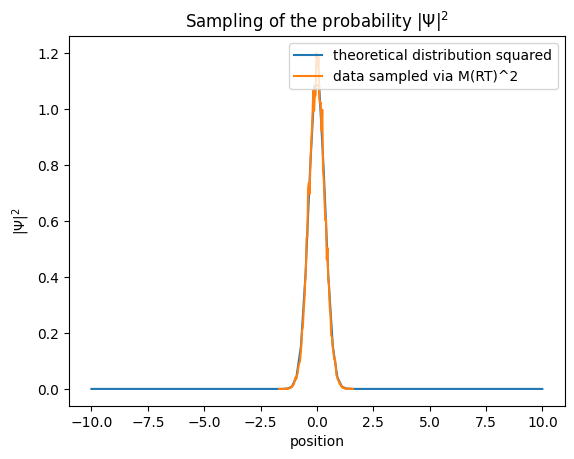

In [ ]:
alpha = 0.5
n_steps = 100000
delta = 2

def distribution(x, params):
    return np.exp(-x ** 2 / 2 / params["alpha"] ** 2)

walker = Walker_Harmonic(np.array(0.), alpha)
firstsol = IntegrateObservables(walker, n_steps, delta)
firstsol.run()
positions = firstsol.positions
energies = firstsol.energies

# binning of the positions
x = np.linspace(-10, 10, 100)
binned_postitions_count, binned_positions_edge, _ = binned_statistic(positions, positions, statistic = "count", bins=100)
binned_positions_edge = binned_positions_edge[:-1] + (binned_positions_edge[1] - binned_positions_edge[0]) / 2

# normalizations
norm_distrib = np.sqrt ( simpson(distribution(x, {"alpha": alpha}) ** 2, x) )
norm_hist = simpson(binned_postitions_count, binned_positions_edge)
print("norm distrib = {:.2f} norm hist = {:.2f}".format(norm_distrib, norm_hist))


plt.plot(x, (distribution(x, {"alpha": alpha}) / norm_distrib) ** 2, label = "theoretical distribution squared")
plt.plot(binned_positions_edge, binned_postitions_count / norm_hist, label = "data sampled via M(RT)^2") 
plt.legend(loc = "upper right")
plt.title("Sampling of the probability $|\Psi|^2$")
plt.xlabel("position")
plt.ylabel("$|\Psi|^2$")
plt.show()


We find how the $M(RT)^2$ algorithm allows us to correctly sample the distribution, with a value of $\Delta \approx 2$ we obtain an acceptance probability of $\approx 0.5$ which is what we are looking for.

Once the hystogram is produced we see how this is not normalized, this is to be expected as the integral of the hystogram is related to the number of steps used to produce it. 

## Local energy 

### Error of $10^{-4}$

observable energies = 1.071e+00 \pm 2.922e-03. Relative error = 2.729e-03


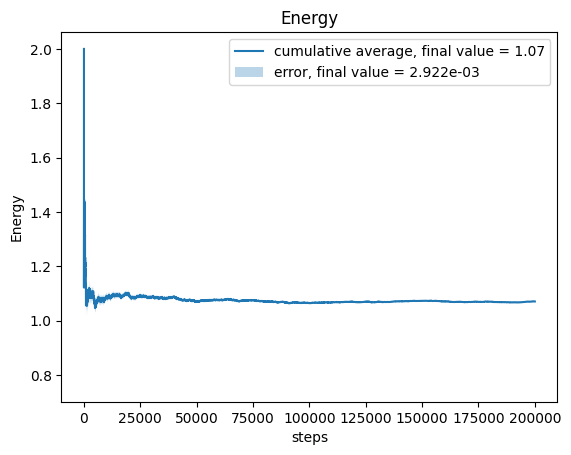

In [ ]:
n_steps = 200000
delta = 0.6
alpha = 0.5

walker = Walker_Harmonic(np.array(0.), alpha)
firstsol = IntegrateObservables(walker, n_steps, delta, compute_Kestimators = False)
firstsol.run()
out = firstsol.get_results()

res = final_results_wvar(out, "energies", title = "Energy", xlabel = "steps", ylabel = "Energy")

### Error of $10^{-5}$

The error on the energy scales as $\frac{1}{\sqrt{N}}$, meaning that to decrease the error from $10^{-4}$ to $10^{-5}$ we would need to increase $N$ by a factor of $100$. This would require $N = 2 \cdot 10^8$ that is not convenient in python as it would take multiple hours. We thus produced a `c++` routine to compute this result, finding indeed the expected scaling, as can be observed below.

In [ ]:
! g++ quickmc.cpp -o quickmc.out

In [ ]:
! ./quickmc.out 2000000

number of steps: 2000000
Energy average: 1.06202
Energy error: 0.000938869
Relative error: 0.000884039


In [ ]:
! ./quickmc.out 200000000

number of steps: 200000000
Energy average: 1.06349
Energy error: 9.34908e-05
Relative error: 8.79095e-05


### Equilibration

Acceptance probability = 0.51
observable energies = 1.082e+00 \pm 9.088e-03. Relative error = 8.399e-03


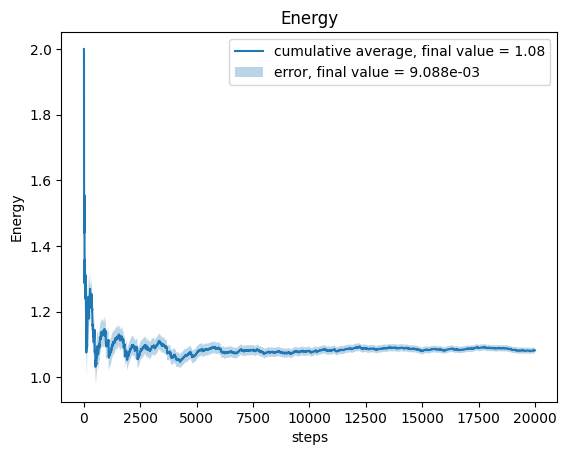

observable K1 = 1.021e+00 \pm 9.693e-03. Relative error = 9.496e-03


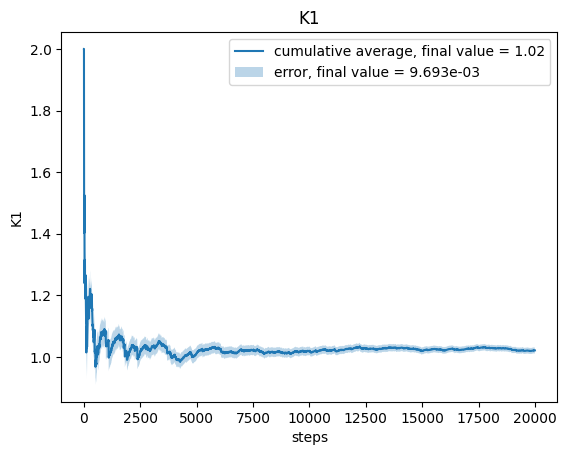

observable K2 = 9.792e-01 \pm 9.693e-03. Relative error = 9.899e-03


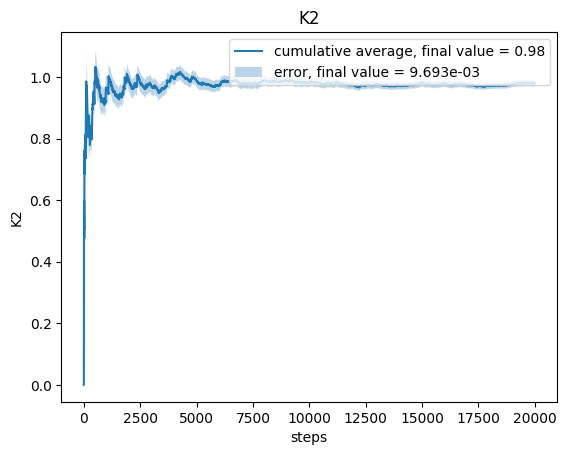

observable K3 = 1.000e+00 \pm 0.000e+00. Relative error = 0.000e+00


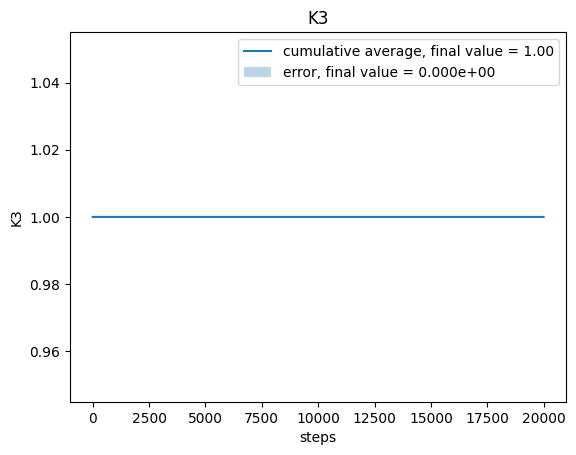

In [ ]:
n_steps = 20000
delta = 1
alpha = 0.5

walker = Walker_Harmonic(np.array(0.), alpha)
firstsol = IntegrateObservables(walker, n_steps, delta)
firstsol.run()
out = firstsol.get_results()

print("Acceptance probability = {:.2f}".format(out["num_accepted"] / n_steps))

outen = final_results_wvar(out, "energies", title = "Energy", xlabel = "steps", ylabel = "Energy")
outk1 = final_results_wvar(out, "K1", title = "K1", xlabel = "steps", ylabel = "K1")
outk2 = final_results_wvar(out, "K2", title = "K2", xlabel = "steps", ylabel = "K2")
outk3 = final_results_wvar(out, "K3", title = "K3", xlabel = "steps", ylabel = "K3")

We can individuate a equilibration region up until `n_steps = 6000`, we can compute the average and error with and without this region to evaluate the impact. Note that by changing the value of $\Delta$ the equilibration region changes significantly, reducing as the acceptance probability increases.

In [ ]:
outen = final_results_wvar(out, "energies", title = "Energy", xlabel = "steps", ylabel = "Energy", verbose = False, eq_steps=10000)
outk1 = final_results_wvar(out, "K1", title = "K1", xlabel = "steps", ylabel = "K1", verbose = False, eq_steps=10000)
outk2 = final_results_wvar(out, "K2", title = "K2", xlabel = "steps", ylabel = "K2", verbose = False, eq_steps=10000)
outk3 = final_results_wvar(out, "K3", title = "K3", xlabel = "steps", ylabel = "K3", verbose = False, eq_steps=10000)

str = """
estimator |   value    | relative error
k1        | {:.3e}  | {:.3e}
k2        | {:.3e}  | {:.3e}
k3        | {:.3e}  | {:.3e}"""\
.format(outk1[0][-1], np.sqrt(outk1[1][-1]), outk2[0][-1], np.sqrt(outk2[1][-1]), outk3[0][-1], np.sqrt(outk3[1][-1]))
print(str)




estimator |   value    | relative error
k1        | 1.022e+00  | 1.364e-02
k2        | 9.777e-01  | 1.364e-02
k3        | 1.000e+00  | 0.000e+00


We can see how in this case without considering the equilibration region the variance does not change considerably, this may be due to the fact that the variance of the sample average depends on the number of samples and here we are removing a substantial number of samples. It is however noted how removing the equilibration region should remove biases in the averages that do persist even for large values of $N$. This is verified by the fact that the accordance between the three kinetic energy estimators is considerably better by removing the equilibration regions in the averages

## Helium ions in an harmonic trap

We are going to use $\varepsilon = 10.4 K$ as a scale for energy (assuming $k_B = 1$) and $\sigma = 2.556 \AA$ as a scale for lengths. Made these choices we can rewrite the hamiltonian (the $\tilde{x}$ represents adimensional units),

$$
\tilde{H} = \frac{\hbar^2}{2 m \sigma ^ 2} \frac{1}{\varepsilon} \sum_{i = 1}^2 \big[ - \frac{\tilde{\nabla_i}^2}{2} + \frac{1}{2}\frac{m^2\omega^2\sigma^4}{\hbar^2} \tilde{r}_i^2 \big] + \tilde{V}_{LJ}(\tilde{r}_{12}) = \\
= C \sum_{i = 1}^2 \big[ - \frac{\tilde{\nabla_i}^2}{2} + \frac{1}{2}\frac{\sigma^4}{a_0^4} \tilde{r}_i^2 \big] + \tilde{V}_{LJ}(\tilde{r}_{12})
$$

where $\frac{\sigma^4}{a_0^4} = 0.0683$ and $ C \equiv \frac{\hbar^2}{2 m \sigma ^ 2} \frac{1}{\varepsilon} = 0.178$.

Finally, for what concernes the local energy: 

$$
\begin{equation}
\tilde{E}_{L, \alpha, \beta}(\tilde{\mathbf{r}}_1,\tilde{\mathbf{r}}_2) = - C \frac{\tilde{\nabla}^2_1 \tilde{\Psi_T}(\alpha,\beta,\tilde{\mathbf{r}}_1,\tilde{\mathbf{r}}_2) + \tilde{\nabla}^2_2 \tilde{\Psi_T}(\alpha,\beta,\tilde{\mathbf{r}}_1,\tilde{\mathbf{r}}_2)}{\tilde{\Psi_T}(\alpha,\beta,\tilde{\mathbf{r}}_1,\tilde{\mathbf{r}}_2)} + \tilde{V}_{LJ}(\tilde{r}_{12})
\end{equation}
$$

In [ ]:
# global variables
C = 0.178
len_conv = 0.0683

In [ ]:
class Walker_HE(Walker):
    def __init__(self, position, alpha, beta):
        super().__init__(position)
        self.alpha = alpha
        self.beta = beta

    def position_shape(self):
        return (2, 3)
    
    def compute_logprobability(self):
        distance = np.sqrt(np.dot(self.position[0] - self.position[1], self.position[0] - self.position[1]))
        self.logprobability = 2 * (-(np.dot(self.position[0], self.position[0]) + np.dot(self.position[1], self.position[1])) / 2 / self.alpha ** 2 
                                   - (self.beta / distance) ** 5)
        
    def compute_Kinetic(self):
        distance = np.sqrt(np.dot(self.position[0] - self.position[1], self.position[0] - self.position[1]))
        p1sq = np.dot(self.position[0], self.position[0])
        p2sq = np.dot(self.position[1], self.position[1])
        grad1f = - 1 / self.alpha ** 2 * self.position[0]
        grad2f = - 1 / self.alpha ** 2 * self.position[1]
        lap1f = p1sq / self.alpha ** 4 - 3 / self.alpha ** 2
        lap2f = p2sq / self.alpha ** 4 - 3 / self.alpha ** 2
        grad1g = 5 * self.beta ** 5 / distance ** 7 * (self.position[0] - self.position[1])
        grad2g = - 5 * self.beta ** 5 / distance ** 7 * (self.position[0] - self.position[1])
        lap1g = 5 * self.beta ** 5 / distance ** 7 * (5 * self.beta ** 5 / distance ** 5 - 4)
        lap2g = 5 * self.beta ** 5 / distance ** 7 * (5 * self.beta ** 5 / distance ** 5 - 4)
        self.localK1 = - C * ((lap1f + lap1g + 2 * np.dot(grad1f, grad1g)) + (lap2f + lap2g + 2 * np.dot(grad2f, grad2g)))
        self.localK2 = C * (np.dot(grad1f + grad1g, grad1f + grad1g) + np.dot(grad2f + grad2g, grad2f + grad2g))
        self.localK3 = 1 / 2 * (self.localK1 + self.localK2)        
        self.localK1sq = self.localK1 ** 2
        self.localK2sq = self.localK2 ** 2
        self.localK3sq = self.localK3 ** 2
    
    def compute_U(self):
        distancesq = np.dot(self.position[0] - self.position[1], self.position[0] - self.position[1])
        return 4 * ((1 / distancesq) ** 6 - (1 / distancesq) ** 3)

Acceptance probability = 0.77
observable energies = 5.932e-01 \pm 1.036e-03. Relative error = 1.746e-03


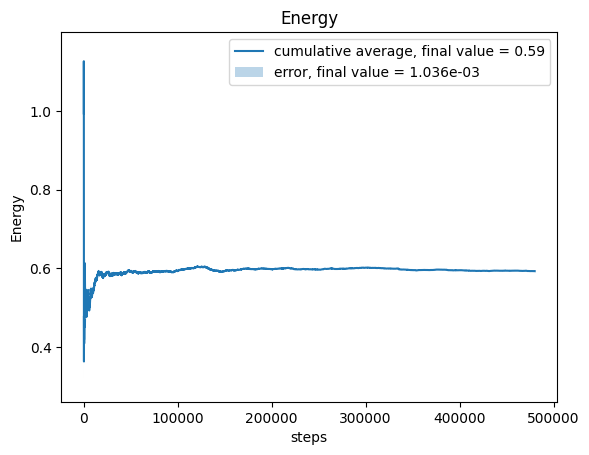

observable K1 = 5.941e-01 \pm 1.036e-03. Relative error = 1.743e-03


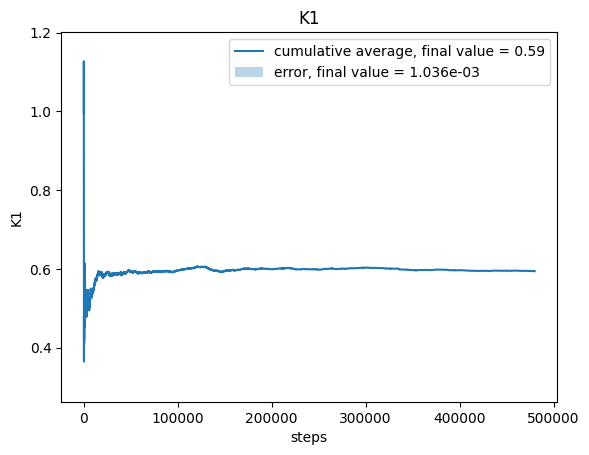

observable K2 = 5.978e-01 \pm 1.246e-03. Relative error = 2.084e-03


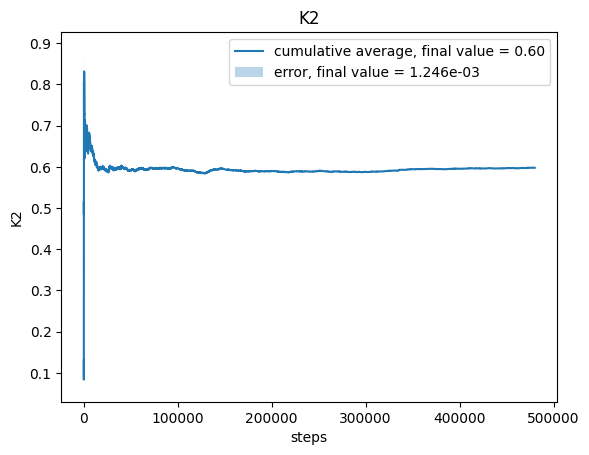

observable K3 = 5.960e-01 \pm 2.825e-04. Relative error = 4.740e-04


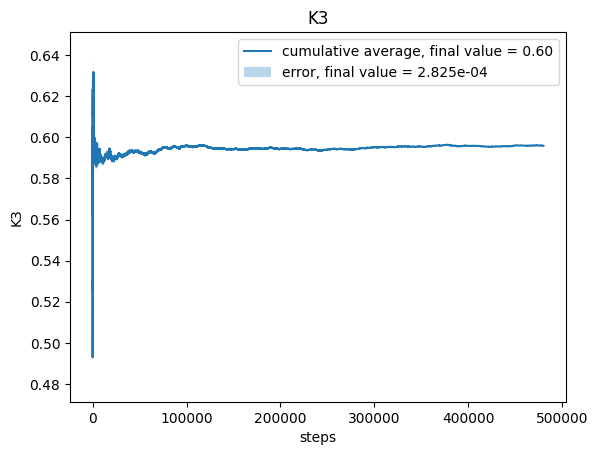


Values for the kinetic energy estimators, should be in agreement with one another
estimator |   value    | error
k1        | 0.594  | 0.001
k2        | 0.598  | 0.001
k3        | 0.596  | 0.000


In [ ]:
n_steps = 500000
delta = 0.3
alpha = 1.2
beta = 4

walker = Walker_HE(np.array([[-1, -1, -1], [1, 1, 1]], dtype = float), alpha, beta)
firstsol = IntegrateObservables(walker,
                                   n_steps,
                                   delta)
firstsol.run()
out = firstsol.get_results()

print("Acceptance probability = {:.2f}".format(out["num_accepted"] / n_steps))

outen = final_results_wvar(out, "energies", title = "Energy", xlabel = "steps", ylabel = "Energy", eq_steps=20000)
outk1 = final_results_wvar(out, "K1", title = "K1", xlabel = "steps", ylabel = "K1", eq_steps=20000)
outk2 = final_results_wvar(out, "K2", title = "K2", xlabel = "steps", ylabel = "K2", eq_steps=20000)
outk3 = final_results_wvar(out, "K3", title = "K3", xlabel = "steps", ylabel = "K3", eq_steps=20000)

str = """
Values for the kinetic energy estimators, should be in agreement with one another
estimator |   value    | error
k1        | {:.3f}  | {:.3f}
k2        | {:.3f}  | {:.3f}
k3        | {:.3f}  | {:.3f}"""\
.format(outk1[0][-1], np.sqrt(outk1[1][-1]), outk2[0][-1], np.sqrt(outk2[1][-1]), outk3[0][-1], np.sqrt(outk3[1][-1]))
print(str)

## Energy minimization

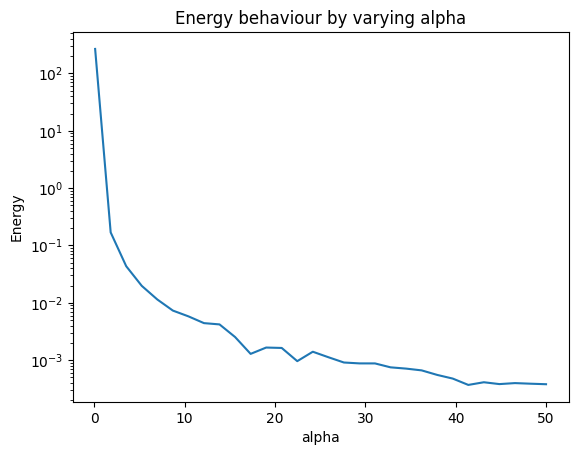

In [ ]:
n_steps = 30000
beta = 1
alphas = np.linspace(.1, 50, 30)
energies = np.zeros(30)

for i, alpha in enumerate(alphas):
    sys.stdout.write('\r')
    sys.stdout.write("i: {}".format(i))
    sys.stdout.flush()
    walker = Walker_HE(np.array([[-1, -1, -1], [1, 1, 1]], dtype = float), alpha, beta)
    firstsol = IntegrateObservables(walker,
                                       n_steps,
                                       delta)
    firstsol.run()
    energies[i] = np.mean(firstsol.energies)
    energiesvar = (np.mean(firstsol.energiessq) - energies[i] ** 2) / (n_steps)

plt.plot(alphas, energies)
plt.title("Energy behaviour by varying alpha")
plt.xlabel("alpha")
plt.ylabel("Energy")
plt.yscale("log")
plt.show()

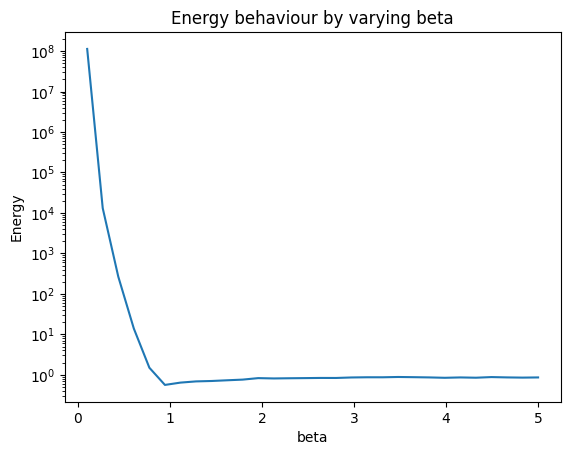

In [ ]:
n_steps = 30000
betas = np.linspace(.1, 5, 30)
alpha = 1
# alphas = np.linspace(1, 1.5, 20)
alphas = [1]
energies = np.zeros(30)

for i, beta in enumerate(betas):
    sys.stdout.write('\r')
    sys.stdout.write("i: {}".format(i))
    sys.stdout.flush()
    walker = Walker_HE(np.array([[-1, -1, -1], [1, 1, 1]], dtype = float), alpha, beta)
    firstsol = IntegrateObservables(walker,
                                       n_steps,
                                       delta)
    firstsol.run()
    energies[i] = np.mean(firstsol.energies)
    energiesvar = (np.mean(firstsol.energiessq) - energies[i] ** 2) / (n_steps)

plt.plot(betas, energies)
plt.title("Energy behaviour by varying beta")
plt.xlabel("beta")
plt.ylabel("Energy")
plt.yscale("log")
plt.show()

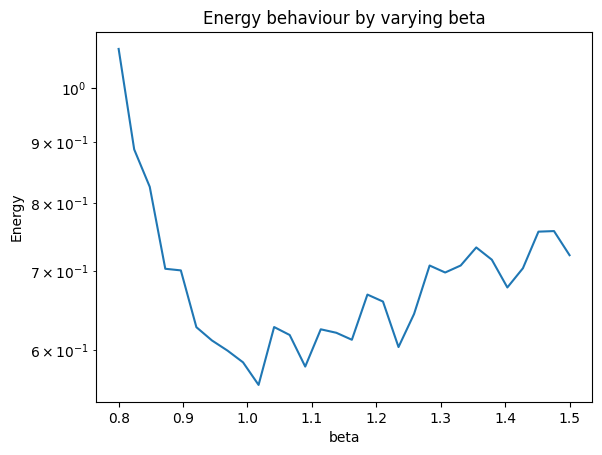

In [ ]:
n_steps = 30000
betas = np.linspace(.8, 1.5, 30)
alpha = 1
alphas = [1]
energies = np.zeros(30)

for i, beta in enumerate(betas):
    sys.stdout.write('\r')
    sys.stdout.write("i: {}".format(i))
    sys.stdout.flush()
    walker = Walker_HE(np.array([[-1, -1, -1], [1, 1, 1]], dtype = float), alpha, beta)
    firstsol = IntegrateObservables(walker,
                                       n_steps,
                                       delta)
    firstsol.run()
    energies[i] = np.mean(firstsol.energies)
    energiesvar = (np.mean(firstsol.energiessq) - energies[i] ** 2) / (n_steps)

plt.plot(betas, energies)
plt.title("Energy behaviour by varying beta")
plt.xlabel("beta")
plt.ylabel("Energy")
plt.yscale("log")
plt.show()

## Conclusions

We see how the M(RT)^2 algorithm works well to sample generic probability distributions.  \
We also found in both the harmonic oscillator and the trapped $He$ case that the computed observables converge in a reasonable number of steps and that the error on the observables scales like $\frac{1}{\sqrt{N}}$ ($N$ being the number of steps) as expected. \
In regard to the kinetic energy estimators, we observed that they in fact agree with each other (provided that in the averaging process the equilibration region is discarded), suggesting the fact that the algorithm and the calculations should be well implemented. \
A note on the errors: the presented errors are the squared root of the variance of the sample. This is an under-estimation of the error because of the fact that we are implicitly assuming consequent steps to be uncorrelated. To mitigate this effect, thus obtaining a more accurate error, it is possible to use a procedure called _blocking_ to estimate autocorrelation times and thus apply a correction to the error. We did not implement this method here. \
Regarding finally the minimization of the wavefunction parameters in the case of the interacting $He$, we found that the optimal value of $\beta \approx 1.01$ while for $\alpha$ the higher the value the closer to $0$ the energy.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8e4126dc-f129-4e98-a27d-950fd08f732c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>